In [1]:
import os
os.chdir('K:/ecole/github/televerser/wisdom of crowds')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### ETL

In [2]:
#read data
y0matrix2019=pd.read_csv('y0matrix2019.csv')

y1matrix2020=pd.read_csv('y1matrix2020.csv')

monthly=pd.read_csv('monthly.csv')

annual=pd.read_csv('annual.csv')

In [3]:
#set index
y0matrix2019.set_index('Source Name',inplace=True)

y1matrix2020.set_index('Source Name',inplace=True)

monthly.set_index('Date',inplace=True)
monthly.index=pd.to_datetime(monthly.index)
monthly.columns=y0matrix2019.columns

annual=annual.pivot(index='Date',columns='Name',values='Value')
annual.index=pd.to_datetime(annual.index)

### Mean Absolute Error

In [4]:
#compute forecast error
y0matrix2019_erreur=np.subtract(y0matrix2019,annual['2019':'2019'])

y1matrix2020_erreur=np.subtract(y1matrix2020,annual['2020':'2020'])

In [5]:
#compute percentage error
erreur_y0=abs(np.divide(y0matrix2019_erreur,annual['2019':'2019']))

erreur_y1=abs(np.divide(y1matrix2020_erreur,annual['2020':'2020']))

In [6]:
#compute forecast error by banks and sort
erreur_by_banks_y0=dict(zip(erreur_y0.index,
                            erreur_y0.mean(axis=1)))
erreur_by_banks_y0=dict(sorted(erreur_by_banks_y0.items(),
                               key=lambda X:X[1]))

erreur_by_banks_y1=dict(zip(erreur_y1.index,
                            erreur_y1.mean(axis=1)))
erreur_by_banks_y1=dict(sorted(erreur_by_banks_y1.items(),
                               key=lambda X:X[1]))

In [7]:
#compute forecast error by commodities and sort
erreur_by_commodities_y0=dict(zip(erreur_y0.columns,erreur_y0.mean(axis=0)))
erreur_by_commodities_y0=dict(sorted(erreur_by_commodities_y0.items(),
                                  key=lambda X:X[1]))

erreur_by_commodities_y1=dict(zip(erreur_y1.columns,erreur_y1.mean(axis=0)))
erreur_by_commodities_y1=dict(sorted(erreur_by_commodities_y1.items(),
                                  key=lambda X:X[1]))

In [8]:
#compute forecast error by using spot price
y0spot2019_erreur=np.divide(monthly['2019-08':'2019-08'],
                            annual['2019':'2019'])-1
y1spot2020_erreur=np.divide(monthly['2019-08':'2019-08'],
                            annual['2020':'2020'])-1

#take abs and convert to dict
erreur_by_spot_y0=list(abs(
    y0spot2019_erreur).to_dict(orient='index').values())[0]

erreur_by_spot_y1=list(abs(
    y1spot2020_erreur).to_dict(orient='index').values())[0]

In [9]:
#compute unit volatility
unit_volatility=monthly.std()/monthly.mean()
unit_volatility=unit_volatility.reindex(erreur_by_commodities_y1.keys())

### Direction

In [10]:
#generate forecast data
y0matrix2019_direction_est=np.sign(np.subtract(y0matrix2019,
                                          monthly['2019-08':'2019-08']))

y1matrix2020_direction_est=np.sign(np.subtract(y1matrix2020,
                                          monthly['2019-08':'2019-08']))

#generate actual data
y0matrix2019_direction_act=np.sign(np.subtract(annual['2019':'2019'],
                                        monthly['2019-08':'2019-08']))

y1matrix2020_direction_act=np.sign(np.subtract(annual['2020':'2020'],
                                        monthly['2019-08':'2019-08']))

In [11]:
#check direction accuracy
direction_2019=np.multiply(y0matrix2019_direction_est,
                           y0matrix2019_direction_act)
direction_2020=np.multiply(y1matrix2020_direction_est,
                           y1matrix2020_direction_act)

In [12]:
#melt for groupby
direction_2019.reset_index(inplace=True)
direction_2020.reset_index(inplace=True)

direction_2019=direction_2019.melt(id_vars='Source Name',
    value_vars=[i for i in direction_2019.columns if i!='Source Name'])

direction_2020=direction_2020.melt(id_vars='Source Name',
    value_vars=[i for i in direction_2020.columns if i!='Source Name'])

#use 0 for summation
direction_2019['value']=direction_2019['value'].replace(-1,0)

direction_2020['value']=direction_2020['value'].replace(-1,0)

In [13]:
#compute percentage by banks and sort
direction_by_banks_y0=(
    direction_2019.groupby('Source Name').sum()/len(
        y0matrix2019.columns)).to_dict()['value']
direction_by_banks_y0=dict(sorted(direction_by_banks_y0.items(),
                               key=lambda X:X[1]))

direction_by_banks_y1=(
    direction_2020.groupby('Source Name').sum()/len(
        y1matrix2020.columns)).to_dict()['value']
direction_by_banks_y1=dict(sorted(direction_by_banks_y1.items(),
                               key=lambda X:X[1]))

#compute percentage by commodities and sort
direction_by_commodities_y0=(
    direction_2019.groupby('variable').sum()/len(
        y0matrix2019)).to_dict()['value']
direction_by_commodities_y0=dict(sorted(direction_by_commodities_y0.items(),
                               key=lambda X:X[1]))

direction_by_commodities_y1=(
    direction_2020.groupby('variable').sum()/len(
        y1matrix2020)).to_dict()['value']
direction_by_commodities_y1=dict(sorted(direction_by_commodities_y1.items(),
                               key=lambda X:X[1]))

### Y+0 Error Viz

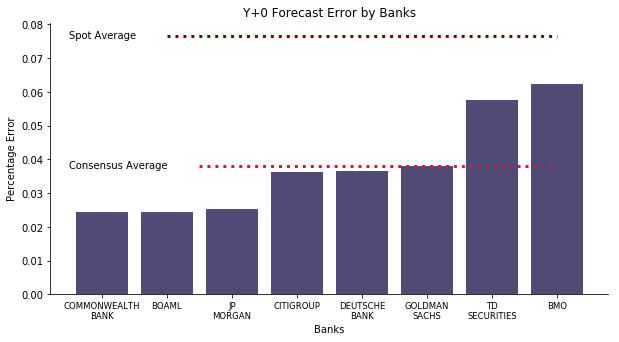

In [14]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(len(erreur_by_banks_y0)),
        erreur_by_banks_y0.values(),
        color='#504a77')
plt.text(-0.5,erreur_y0.mean().mean(),
         'Consensus Average',va='center')
plt.hlines(erreur_y0.mean().mean(),
           xmin=1.5,xmax=len(erreur_by_banks_y0)-1,
           linestyle=':',color='crimson',lw=3)
plt.text(-0.5,np.mean(list(erreur_by_spot_y0.values())),
         'Spot Average',va='center')
plt.hlines(np.mean(list(erreur_by_spot_y0.values())),
           xmin=1,xmax=len(erreur_by_banks_y0)-1,
           linestyle=':',color='maroon',lw=3)
plt.xticks(range(len(erreur_by_banks_y0)),
           [i.replace(' ','\n') for i in erreur_by_banks_y0.keys()],
           fontsize=8.5)
plt.xlabel('Banks')
plt.ylabel('Percentage Error')
plt.title('Y+0 Forecast Error by Banks')
plt.show()

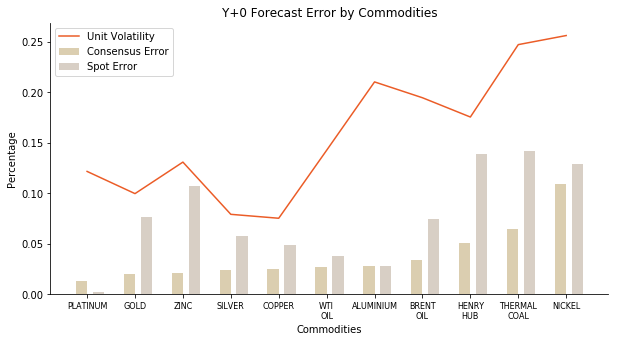

In [15]:
#viz
section_width=7
bar_width=4
intra_width=2
ticks=[]

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ind,val in enumerate(erreur_by_commodities_y0):
    x1=(ind+1)*section_width+(2*ind)*bar_width+ind*intra_width
    tick=x1+bar_width/2
    x2=x1+bar_width+intra_width
    bar1=plt.bar(x1,erreur_by_commodities_y0[val],
            color='#DBCEB0',width=bar_width)
    bar2=plt.bar(x2,erreur_by_spot_y0[val],
            color='#d8cfc5',width=bar_width)
    ticks.append(tick)
line,=plt.plot(ticks,unit_volatility,
         label='Volatility',c='#eb5c27')
plt.xticks(ticks,
           [i.replace(' ','\n') for i in erreur_by_commodities_y0.keys()],
           fontsize=8)
plt.legend((line,bar1,bar2),
           ('Unit Volatility','Consensus Error','Spot Error'),loc=0)
plt.xlabel('Commodities')
plt.ylabel('Percentage')
plt.title('Y+0 Forecast Error by Commodities')
plt.show()

### Y+1 Error Viz

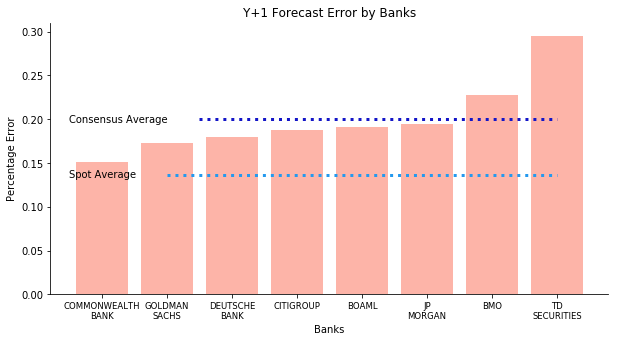

In [16]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(len(erreur_by_banks_y1)),
        erreur_by_banks_y1.values(),
        color='#fc6b52',alpha=0.5)
plt.text(-0.5,erreur_y1.mean().mean(),
         'Consensus Average',va='center')
plt.hlines(erreur_y1.mean().mean(),
           xmin=1.5,xmax=len(erreur_by_banks_y1)-1,
           linestyle=':',color='#1315c7',lw=3)
plt.text(-0.5,np.mean(list(erreur_by_spot_y1.values())),
         'Spot Average',va='center')
plt.hlines(np.mean(list(erreur_by_spot_y1.values())),
           xmin=1,xmax=len(erreur_by_banks_y1)-1,
           linestyle=':',color='#2499ee',lw=3)
plt.xticks(range(len(erreur_by_banks_y1)),
           [i.replace(' ','\n') for i in erreur_by_banks_y1.keys()],
           fontsize=8.5)
plt.xlabel('Banks')
plt.ylabel('Percentage Error')
plt.title('Y+1 Forecast Error by Banks')
plt.show()

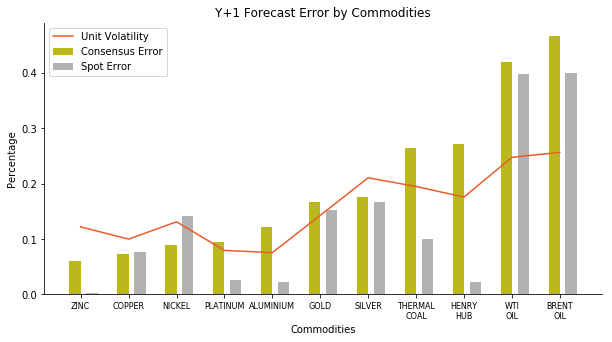

In [17]:
#viz
section_width=7
bar_width=4
intra_width=2
ticks=[]

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for ind,val in enumerate(erreur_by_commodities_y1):
    x1=(ind+1)*section_width+(2*ind)*bar_width+ind*intra_width
    tick=x1+bar_width/2
    x2=x1+bar_width+intra_width
    bar1=plt.bar(x1,erreur_by_commodities_y1[val],
            color='#bab81e',width=bar_width)
    bar2=plt.bar(x2,erreur_by_spot_y1[val],
            color='#B2B2B2',width=bar_width)
    ticks.append(tick)
line,=plt.plot(ticks,unit_volatility,
         label='Volatility',c='#eb5c27')
plt.xticks(ticks,
           [i.replace(' ','\n') for i in erreur_by_commodities_y1.keys()],
           fontsize=8)
plt.legend((line,bar1,bar2),
           ('Unit Volatility','Consensus Error','Spot Error'),loc=0)
plt.xlabel('Commodities')
plt.ylabel('Percentage')
plt.title('Y+1 Forecast Error by Commodities')
plt.show()

### Y+0 Direction Viz

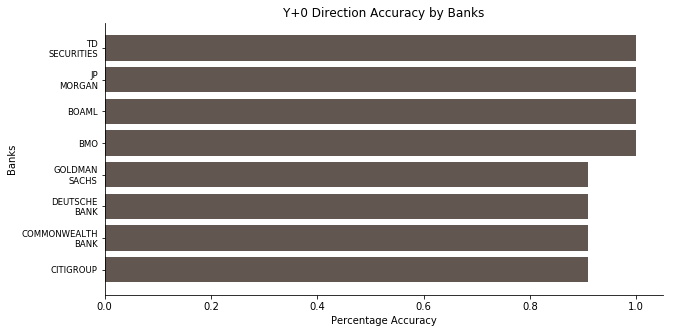

In [18]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.barh(range(len(direction_by_banks_y0)),
        list(direction_by_banks_y0.values()),
        color='#625750')
plt.yticks(range(len(direction_by_banks_y0)),
           [i.replace(' ','\n') for i in direction_by_banks_y0.keys()],
           fontsize=8.5)
plt.ylabel('Banks')
plt.xlabel('Percentage Accuracy')
plt.title('Y+0 Direction Accuracy by Banks')
plt.show()

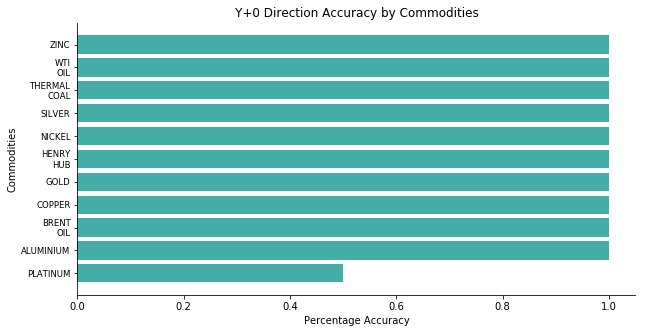

In [19]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.barh(range(len(direction_by_commodities_y0)),
        list(direction_by_commodities_y0.values()),
        color='#45ADA8')
plt.yticks(range(len(direction_by_commodities_y0)),
           [i.replace(' ','\n') for i in direction_by_commodities_y0.keys()],
           fontsize=8.5)
plt.ylabel('Commodities')
plt.xlabel('Percentage Accuracy')
plt.title('Y+0 Direction Accuracy by Commodities')
plt.show()

### Y+1 Direction Viz

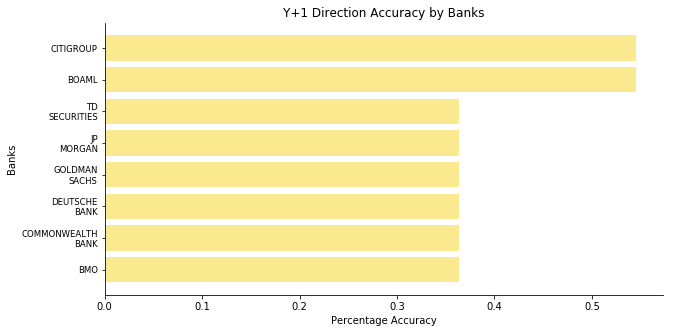

In [20]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.barh(range(len(direction_by_banks_y1)),
        list(direction_by_banks_y1.values()),
        color='#F9D423',alpha=0.5)
plt.yticks(range(len(direction_by_banks_y1)),
           [i.replace(' ','\n') for i in direction_by_banks_y1.keys()],
           fontsize=8.5)
plt.ylabel('Banks')
plt.xlabel('Percentage Accuracy')
plt.title('Y+1 Direction Accuracy by Banks')
plt.show()

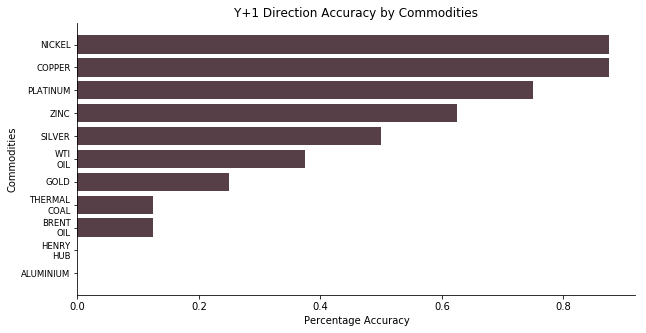

In [21]:
#viz
ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.barh(range(len(direction_by_commodities_y1)),
        list(direction_by_commodities_y1.values()),
        color='#563F46')
plt.yticks(range(len(direction_by_commodities_y1)),
           [i.replace(' ','\n') for i in direction_by_commodities_y1.keys()],
           fontsize=8.5)
plt.ylabel('Commodities')
plt.xlabel('Percentage Accuracy')
plt.title('Y+1 Direction Accuracy by Commodities')
plt.show()

### Wisdom of Crowds

In [22]:
#take average of consensus and compute its percentage error
consensus_y0=np.divide(y0matrix2019.mean().tolist(),annual['2019':'2019'])-1

consensus_y1=np.divide(y1matrix2020.mean().tolist(),annual['2020':'2020'])-1

#cleanse column names
consensus_y0.columns=y0spot2019_erreur.columns
consensus_y1.columns=y1spot2020_erreur.columns

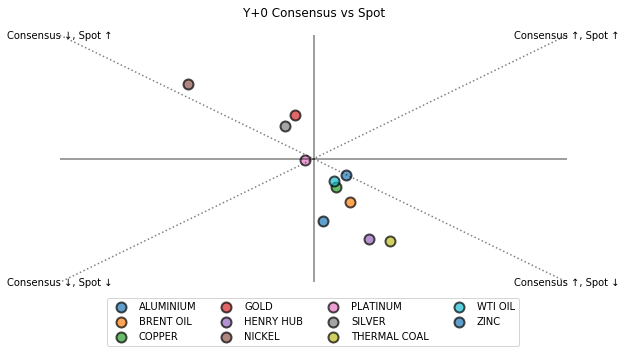

In [23]:
#viz
maxval=np.abs([consensus_y0.T.min().item(),
    consensus_y0.T.max().item(),
    y0spot2019_erreur.T.min().item(),
    y0spot2019_erreur.T.max().item()]).max()*1.5

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.hlines(0,xmin=-maxval,xmax=maxval,alpha=0.5)
plt.vlines(0,ymin=-maxval,ymax=maxval,alpha=0.5)
plt.text(maxval,maxval,'Consensus ↑, Spot ↑',ha='center',va='center')
plt.text(maxval,-maxval,'Consensus ↑, Spot ↓',ha='center',va='center')
plt.text(-maxval,maxval,'Consensus ↓, Spot ↑',ha='center',va='center')
plt.text(-maxval,-maxval,'Consensus ↓, Spot ↓',ha='center',va='center')
plt.plot([maxval,-maxval],[maxval,-maxval],
        linestyle=':',alpha=0.5,c='k')
plt.plot([-maxval,maxval],[maxval,-maxval],
        linestyle=':',alpha=0.5,c='k')
for i in y0spot2019_erreur:
    plt.scatter(consensus_y0[i].iloc[0],
                y0spot2019_erreur[i].iloc[0],label=i,
                s=100,alpha=0.7,lw=2,edgecolors='k')

plt.xticks([])
plt.yticks([])
plt.legend(loc=6,bbox_to_anchor=(0.12, -0.1), ncol=4)
plt.title('Y+0 Consensus vs Spot')
plt.show()

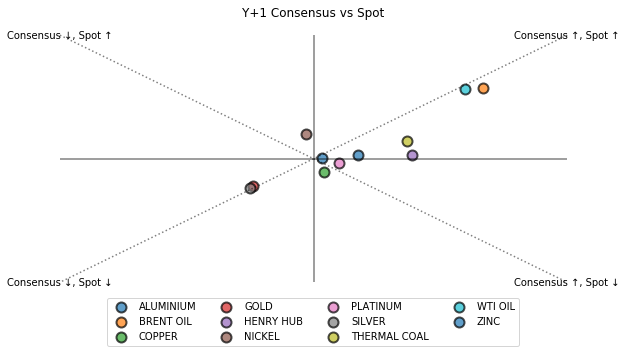

In [24]:
#viz
maxval=np.abs([consensus_y1.T.min().item(),
    consensus_y1.T.max().item(),
    y1spot2020_erreur.T.min().item(),
    y1spot2020_erreur.T.max().item()]).max()*1.5

ax=plt.figure(figsize=(10,5)).add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.hlines(0,xmin=-maxval,xmax=maxval,alpha=0.5)
plt.vlines(0,ymin=-maxval,ymax=maxval,alpha=0.5)
plt.text(maxval,maxval,'Consensus ↑, Spot ↑',ha='center',va='center')
plt.text(maxval,-maxval,'Consensus ↑, Spot ↓',ha='center',va='center')
plt.text(-maxval,maxval,'Consensus ↓, Spot ↑',ha='center',va='center')
plt.text(-maxval,-maxval,'Consensus ↓, Spot ↓',ha='center',va='center')
plt.plot([maxval,-maxval],[maxval,-maxval],
        linestyle=':',alpha=0.5,c='k')
plt.plot([-maxval,maxval],[maxval,-maxval],
        linestyle=':',alpha=0.5,c='k')
for i in y1spot2020_erreur:
    plt.scatter(consensus_y1[i].iloc[0],
                y1spot2020_erreur[i].iloc[0],label=i,
                s=100,alpha=0.7,lw=2,edgecolors='k')

plt.xticks([])
plt.yticks([])
plt.legend(loc=6,bbox_to_anchor=(0.12, -0.1), ncol=4)
plt.title('Y+1 Consensus vs Spot')
plt.show()